In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flavio
import weight_calulations as wc
from tqdm import tqdm

from functools import lru_cache

# Weighted Grid
One issue with re-weighing the dataset that we have generated according to the standard model is that it introduces bias into the new physics. Ideally, we would have a new dataset instead of having to re-weight it every time. One approximation to this is to have a grid of points which we can re-weight according to each model. This removes the bias from the original model used to generate the data.

## Generate 3d grid

In [154]:
# %matplotlib notebook

In [201]:
points_per_axis = 16
number_of_features = 3
grid = np.ones([points_per_axis] * number_of_features)

q_range = np.linspace(0.5,2, points_per_axis)
l_range = np.linspace(0,np.pi, points_per_axis)
k_range = np.linspace(0,np.pi, points_per_axis)
p_range = np.linspace(-np.pi,np.pi, points_per_axis)

In [202]:
x, y, z = np.meshgrid(q_range, k_range, l_range)
x_2d, y_2d = np.meshgrid(k_range, l_range)

In [203]:
obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']

@lru_cache(maxsize=None)
def get_observable_array(q2, c9, c10):
    wilson_coef.set_initial({'C9_bsmumu' : c9, 'C10_bsmumu' : c10}, scale = 100)

    return [flavio.np_prediction(f'{obs}(B0->K*mumu)', wilson_coef, q2) for obs in obs_si]

In [158]:
sm_grid = np.zeros([points_per_axis] * 3)
constant_p = 0

obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
wilson_coef = flavio.WilsonCoefficients()
c9, c10 = 0, 0

for k in range(points_per_axis):
    for j in range(points_per_axis):
        for i in range(points_per_axis):
            k_var = z[k,j,i]
            q2_var = x[k,j,i]
            l_var = y[k,j,i]

            observables_array = get_observable_array(q2_var, c9, c10)

            br = wc.compute_br_array(observables_array, k_var, l_var, constant_p)
            sm_grid[k,j,i] = br
            

In [159]:
opposite_signs_grid = np.zeros([points_per_axis] * 3)
constant_p = 0

obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
wilson_coef = flavio.WilsonCoefficients()
c9, c10 = 1, -1

for k in range(points_per_axis):
    for j in range(points_per_axis):
        for i in range(points_per_axis):
            k_var = z[k,j,i]
            q2_var = x[k,j,i]
            l_var = y[k,j,i]

            observables_array = get_observable_array(q2_var, c9, c10)

            br = wc.compute_br_array(observables_array, k_var, l_var, constant_p)
            opposite_signs_grid[k,j,i] = br

Text(0.5, 0, 'l')

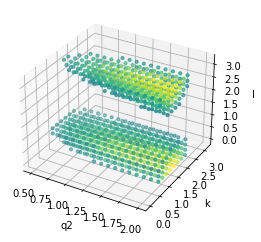

In [160]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c = sm_grid, s=np.where(sm_grid > 7e-1, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

Text(0.5, 0, 'l')

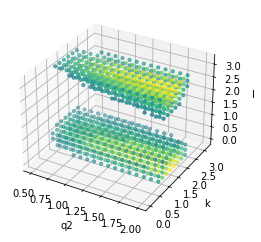

In [161]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c = opposite_signs_grid, s=np.where(opposite_signs_grid > 7e-1, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')

# Generate Dataset

Now generate for a bunch of different wilson coefficients

In [162]:
constant_p = 0
branching_grids = []
wilson_coefficients = []
for c9, c10 in tqdm(np.random.uniform(-10,10,(4_000,2))):
    temp_grid = np.zeros([points_per_axis] * 3)

    obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
    wilson_coef = flavio.WilsonCoefficients()

    for k in range(points_per_axis):
        for j in range(points_per_axis):
            for i in range(points_per_axis):
                k_var = z[k,j,i]
                q2_var = x[k,j,i]
                l_var = y[k,j,i]

                observables_array = get_observable_array(q2_var, c9, c10)

                br = wc.compute_br_array(observables_array, k_var, l_var, constant_p)
                temp_grid[k,j,i] = br
    branching_grids.append(temp_grid)
    wilson_coefficients.append({'c9':c9, 'c10':c10})

  0%|          | 3/4000 [00:02<49:14,  1.35it/s]


KeyboardInterrupt: 

In [182]:
constant_p = 0
constant_q2 = 0.5
branching_grids = []
wilson_coefficients = []
for c9, c10 in tqdm(np.random.uniform(-4,4,(10_000,2))):
    
    c9 = 0

    temp_grid = np.zeros([points_per_axis] * 2)

    obs_si = ['FL', 'AFB', 'S3', 'S4', 'S5', 'S7', 'S8', 'S9']
    wilson_coef = flavio.WilsonCoefficients()

    for k in range(points_per_axis):
        for j in range(points_per_axis):

            k_var = x_2d[k,j]
            l_var = y_2d[k,j]

            observables_array = get_observable_array(constant_q2, c9, c10)

            br = wc.compute_br_array(observables_array, k_var, l_var, constant_p)
            temp_grid[k,j] = br
        # ajsdf

    branching_grids.append(temp_grid)
    wilson_coefficients.append({'c9':c9, 'c10':c10})

100%|██████████| 10000/10000 [08:24<00:00, 19.83it/s]


ValueError: s must be a scalar, or float array-like with the same size as x and y

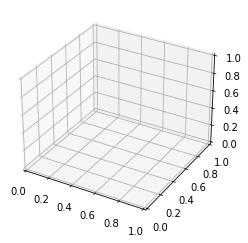

In [181]:
for nn in range(4):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(x, y, z, c= branching_grids[nn], alpha=0.7, s=np.where(branching_grids[nn] > 1e-1, 10, 0))
    ax.set_title(wilson_coefficients[nn])
    ax.set_xlabel('q2')
    ax.set_ylabel('k')
    ax.set_zlabel('l')
    fig.show()

In [183]:
import pickle
from datetime import datetime

now = datetime.now()

outfile_grid = open(f'grids_{now.month}_{now.day}_{now.hour}_fixed.pkl', 'wb')
outfile_coef = open(f'coefficients_{now.month}_{now.day}_{now.hour}_fixed.pkl', 'wb')
pickle.dump(branching_grids, outfile_grid)
pickle.dump(wilson_coefficients, outfile_coef)
outfile_grid.close()
outfile_coef.close()

# CNN

In [249]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import r2_score

In [250]:
infile_grid = open(f'data/grids_1_12_14.pkl', 'rb')
infile_coef = open(f'data/coefficients_1_12_14.pkl', 'rb')
grid_1 = pickle.load(infile_grid)
coef_1 = pickle.load(infile_coef)
infile_grid.close()
infile_coef.close()

## 2D

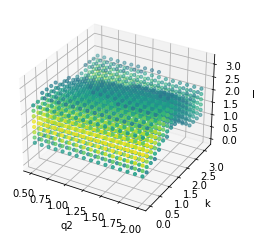

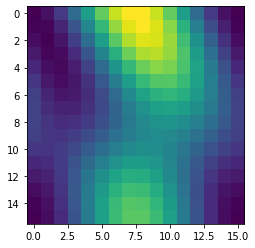

In [87]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ex_grid = branching_grids[0]

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 4e-1, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')
plt.show()

plt.imshow(ex_grid.sum(axis=1))


In [116]:
X_2d = X.sum(axis=2)

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, Y)

[-9.74112676  4.31513128]


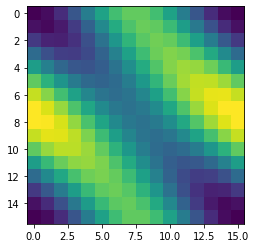

In [119]:
print(Y[3])
plt.imshow(X_2d[3].reshape(16,16))

In [135]:
n = 100
l1 = 10
l2 = 2
out = 2
model_tf_2d = keras.Sequential()
model_tf_2d.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(16,16,1)))
model_tf_2d.add(layers.MaxPool2D((2,2)))
model_tf_2d.add(layers.Conv2D(32,(3,3), activation='relu'))
model_tf_2d.add(layers.Dense(l1, activation='relu'))  # first layer takes in n inputs and outputs to l1 nodes
model_tf_2d.add(layers.Flatten())
model_tf_2d.add(layers.Dense(out, activation='linear'))    # last layer takes in l1 nodes and outputs to out nodes

In [136]:
model_tf_2d.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [137]:
model_tf_2d.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 32)          4640      
_________________________________________________________________
dense_14 (Dense)             (None, 5, 5, 10)          330       
_________________________________________________________________
flatten_7 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 502       
Total params: 5,632
Trainable params: 5,632
Non-trainable params: 0
____________________________________________________

In [138]:
history = model_tf_2d.fit(
    X_train_2d, 
    y_train_2d,
    batch_size=10,
    epochs=20,
    # validation_data=(x_test, y_test)
)


Epoch 1/20
600/600 [==============================] - 2s 2ms/step - loss: 32.9452 - mean_squared_error: 32.9452
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9451 - mean_squared_error: 32.9451
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9450 - mean_squared_error: 32.9450
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9450 - mean_squared_error: 32.9450
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9451 - mean_squared_error: 32.9451
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9450 - mean_squared_error: 32.9450
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9451 - mean_squared_error: 32.9451
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9451 - mean_squared_error: 32.9451
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 32.9450 - mean_squared_error: 

In [139]:
pred = model_tf_2d.predict(X_test_2d)

print(f'R^2    - {r2_score(pred, y_test_2d)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test_2d[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test_2d[:,1])}')

R^2    - 0.0
R^2(a) - 0.0
R^2(b) - 0.0


## 3D

In [251]:
X = np.array(grid_1)
X = X.reshape(X.shape[0], points_per_axis, points_per_axis, points_per_axis, 1)
Y = np.array([list(w.values()) for w in coef_1])
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [272]:
model_3d = keras.Sequential()
model_3d.add(layers.Conv3D(16, (3,3,3), activation='relu', input_shape=(16,16,16,1)))
model_3d.add(layers.MaxPool3D((2,2,2)))
model_3d.add(layers.Conv3D(32, (3,3,3), activation='relu'))
# model_3d.add(layers.MaxPool3D((2,2,2)))
# model_3d.add(layers.Conv3D(40, (3,3,3), activation='relu'))
model_3d.add(layers.Dense(32, activation='relu'))
model_3d.add(layers.Flatten())
model_3d.add(layers.Dense(2, activation='linear'))

model_3d.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

In [275]:
history = model_3d.fit(
    X_train[:100], 
    y_train[:100],
    batch_size=10,
    epochs=10,
    # validation_data=(x_test, y_test)
)

Epoch 1/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 2/10
10/10 [==============================] - 0s 45ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 3/10
10/10 [==============================] - 0s 45ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 4/10
10/10 [==============================] - 0s 45ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 5/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 6/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 7/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 8/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 9/10
10/10 [==============================] - 0s 44ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 10/10
10/10 [

In [276]:
pred = model_3d.predict(X_test)

print(f'R^2    - {r2_score(pred, y_test)}')
print(f'R^2(a) - {r2_score(pred[:,0], y_test[:,0])}')
print(f'R^2(b) - {r2_score(pred[:,1], y_test[:,1])}')

R^2    - 0.9976517283505162
R^2(a) - 0.9983991255642276
R^2(b) - 0.996904331148173


[[-0.8516204  0.2772435]]


<ipython-input-278-b5a122b22005>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


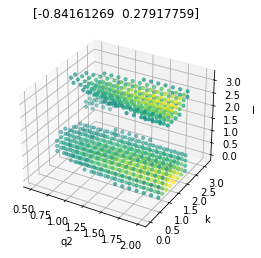

In [278]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

iii = 100
ex_grid = X_test[iii].reshape(16, 16, 16)

print(model_3d.predict(np.array([X_test[iii]])))

ax.scatter(x, y, z, c = ex_grid, s=np.where(ex_grid > 7e-1, 10, 0))
ax.set_xlabel('q2')
ax.set_ylabel('k')
ax.set_zlabel('l')
ax.set_title(y_test[iii])
fig.show()